# Example 6

Solves a plane stress 2D problem using a structured mesh. Shows how to draw von Mises effective stress as an element value with drawElementValues(). Shows use of GmshMesher attribute 'nodesOnCurve' (dictionary that says which nodes are on a given geometry curve)

In [1]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv
import calfem.utils as cfu
import calfem.core as cfc
import numpy as np

from math import sqrt

In [2]:
%matplotlib notebook

## Define problem variables

In [3]:
t = 0.2
v = 0.35
E = 2.1e9
ptype = 1
ep = [ptype,t]
D=cfc.hooke(ptype, E, v)

## Define geometry

In [4]:
g = cfg.geometry()

# Just a shorthand. We use this to make the circle arcs.

s2 = 1/sqrt(2) 

points = [[0, 3], [2.5, 3], [3, 3], [4-s2, 3-s2], [4, 2],     #0-4
          [4+s2, 3-s2], [5, 3], [5.5, 3], [8,3], [0, 1.5],    #5-9
          [2.5, 1.5], [4, 1.5], [5.5, 1.5], [8, 1.5], [0, 0], #10-14
          [2.5, 0], [3, 0], [4-s2, s2], [4, 1], [4+s2, s2],   #15-19
          [5, 0], [5.5, 0], [8,0], [4,3], [4,0]]              #20-24
          
for xp, yp in points:
    g.point([xp*0.1, yp*0.1])

splines = [[0,1], [1,2], [6,7], [7,8], [8,13],          #0-4
           [13,22], [22,21], [21,20], [16,15], [15,14], #5-9
           [14,9], [9,0], [9,10], [10,1], [10, 15],     #10-14
           [10,11], [11,4], [11,18], [11,12], [12,7],   #15-19
           [12,21], [12,13], [3,10], [5,12], [10,17],   #20-24
           [12,19]]                                     #25
           
for s in splines:
    g.spline(s, elOnCurve=10)
    
g.curveMarker(ID=4,  marker=7) #Assign marker 7 to the splines on the right.
g.curveMarker(ID=5,  marker=7) # We will apply a force on nodes with marker 7.
g.curveMarker(ID=10, marker=5) #Assign marker 5 to the splines on the left.
g.curveMarker(ID=11, marker=5) # The nodes with marker 5 will be locked in place.

# Points in circle arcs are [start, center, end]

circlearcs = [[2, 23, 3], [3, 23, 4], [4, 23, 5], [5, 23, 6],           #26-29
              [16, 24, 17], [17, 24, 18], [18, 24, 19], [19, 24, 20]]   #30-33
              
for c in circlearcs:
    g.circle(c, elOnCurve=10)

g.structuredSurface([11,12,13,0]) #0
g.structuredSurface([14, 12, 10, 9])
g.structuredSurface([8, 30, 24, 14])
g.structuredSurface([24, 31, 17, 15])
g.structuredSurface([15, 16, 27, 22]) #4
g.structuredSurface([22, 26, 1, 13]) 
g.structuredSurface([16, 18, 23, 28])
g.structuredSurface([19, 2, 29, 23])
g.structuredSurface([19, 21, 4, 3]) #8
g.structuredSurface([20, 6, 5, 21])
g.structuredSurface([25, 20, 7, 33])
g.structuredSurface([32, 17, 18, 25]) #11

## Create mesh

In [5]:
mesh = cfm.GmshMesh(geometry = g)
mesh.el_type = 3
mesh.dofs_per_node = 2

coords, edof, dofs, bdofs, elementmarkers = mesh.create()

## Solve problem

### Assemble system matrix

In [6]:
nDofs = np.size(dofs)
ex, ey = cfc.coordxtr(edof, coords, dofs)
K = np.zeros([nDofs,nDofs])

for eltopo, elx, ely in zip(edof, ex, ey):
    Ke = cfc.planqe(elx, ely, ep, D)
    cfc.assem(eltopo, K, Ke)

### Solve equation system

In [7]:
f = np.zeros([nDofs,1])

bc = np.array([],'i')
bcVal = np.array([],'f')

bc, bcVal = cfu.applybc(bdofs, bc, bcVal, 5, 0.0, 0)

cfu.applyforce(bdofs, f, 7, 10e5, 1)

a,r = cfc.solveq(K,f,bc,bcVal)

### Compute element forces

In [8]:
ed = cfc.extractEldisp(edof,a)
vonMises = []

# For each element:

for i in range(edof.shape[0]): 

    # Determine element stresses and strains in the element.
    
    es, et = cfc.planqs(ex[i,:], ey[i,:], ep, D, ed[i,:]) 

    # Calc and append effective stress to list.    
    
    vonMises.append( sqrt( pow(es[0],2) - es[0]*es[1] + pow(es[1],2) + 3*es[2] ) ) 

    ## es: [sigx sigy tauxy]

## Visualise results

<IPython.core.display.Javascript object>


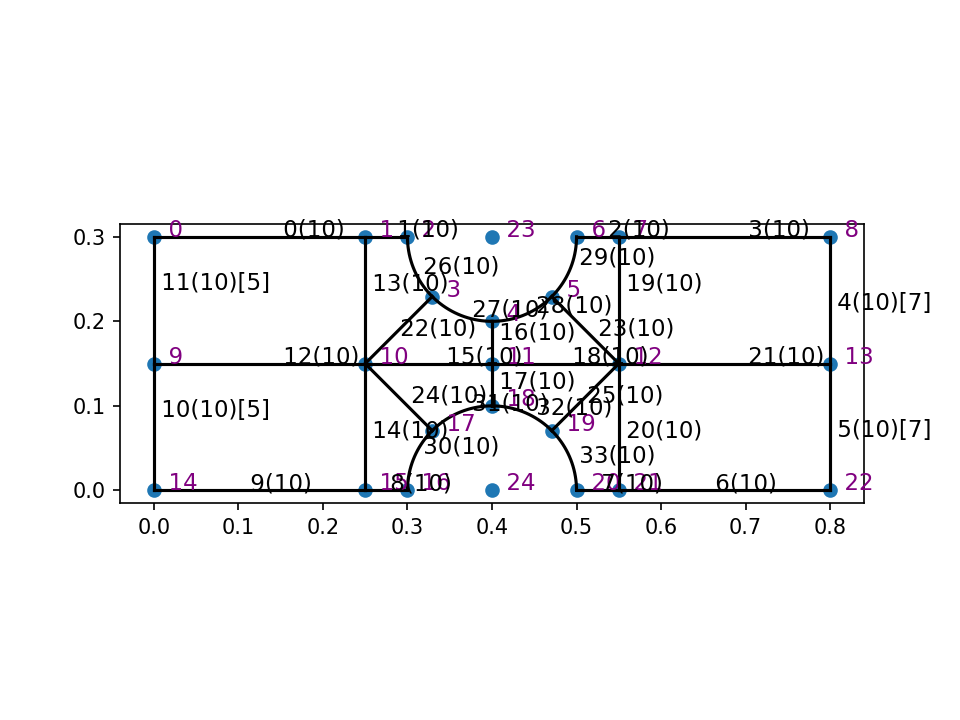

c:\Users\jonas\Development\calfem-python\calfem\vis_mpl.py:692: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.asarray(np.vstack(T * M * CPs[j-1:j+3, :] for j in range(1, len(CPs)-2)))


In [9]:
cfv.figure()
cfv.draw_geometry(g, draw_points=True, label_curves=True, label_points=True)

<IPython.core.display.Javascript object>


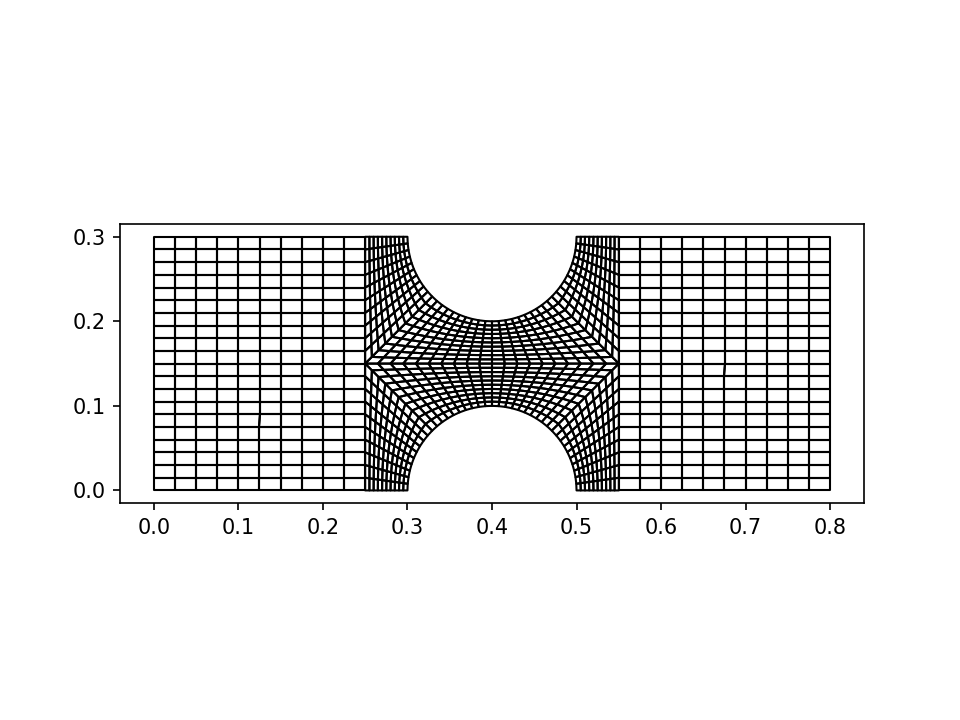

In [10]:
cfv.figure()
cfv.draw_mesh(coords, edof, dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type)

<IPython.core.display.Javascript object>


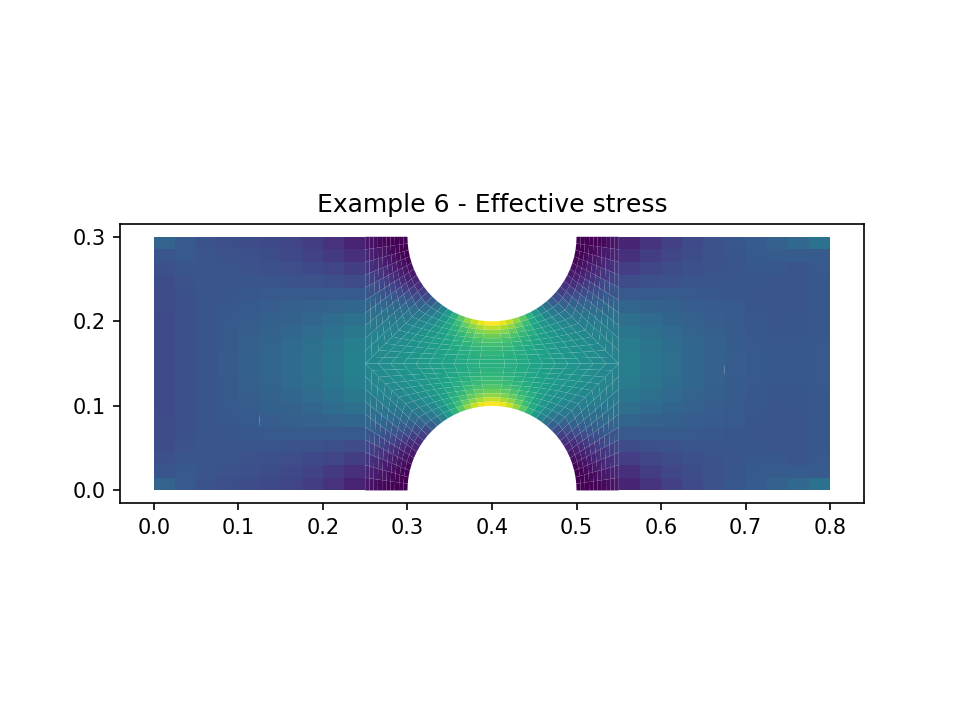

In [11]:
cfv.figure()
cfv.draw_element_values(vonMises, coords, edof, mesh.dofs_per_node, mesh.el_type, None, draw_elements=False, draw_undisplaced_mesh=False, title="Example 6 - Effective stress")

<IPython.core.display.Javascript object>


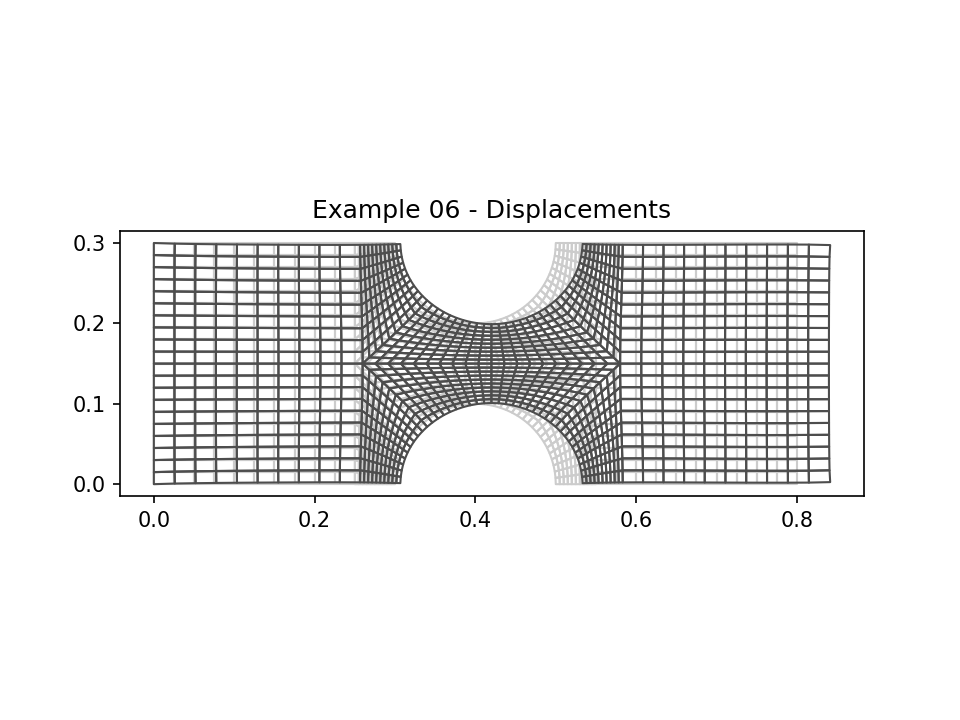

In [13]:
cfv.figure()
cfv.draw_displacements(a, coords, edof, mesh.dofs_per_node, mesh.el_type, draw_undisplaced_mesh=True, title="Example 06 - Displacements")